In [0]:

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers.core import Dropout, Lambda
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from google.colab import drive

drive.mount('/content/drive')

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/My Drive/cs4990-fall2019-finalproject/training_validation_Hair_Skin_Masks/training_hair_skin/images'
# VALIDATION_PATH = '/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images'
TEST_PATH = '/content/drive/My Drive/cs4990-fall2019-finalproject/testing_images/testing_images'
CELEB_A_PATH = '/content/drive/My Drive/cs4990-fall2019-finalproject/celebA_images'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Rename validation images and masks to use in training data
# name = 1
# for filename in os.listdir('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images'):
#   os.rename('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images' + '/' + filename,
#             '/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images' + '/' + 'validation_img_' + str(name) + '.jpg')
#   name += 1

# name = 1
# for filename in os.listdir('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks'):
#   os.rename('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks' + '/' + filename,
#             '/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks' + '/' + 'validation_mask_' + str(name) + '.jpg')
#   name += 1


Using TensorFlow backend.


TensorFlow is already loaded. Please restart the runtime to change versions.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Get train and test and celebA IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
train_mask_ids = next(os.walk('/content/drive/My Drive/cs4990-fall2019-finalproject/training_validation_Hair_Skin_Masks/training_hair_skin/masks'))[2]
train_mask_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
print(train_ids)
print(train_mask_ids)
# validation_ids = next(os.walk(VALIDATION_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]
test_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
print(test_ids)
celebA_ids = next(os.walk(CELEB_A_PATH))[2]
celebA_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
print(celebA_ids)
# print(type(train_ids[0]))
# print(type(validation_ids[0]))
# for i in range(0,len(train_ids)):
#   print(train_ids[i])

['train_img_1.jpg', 'train_img_2.jpg', 'train_img_3.jpg', 'train_img_4.jpg', 'train_img_5.jpg', 'train_img_6.jpg', 'train_img_7.jpg', 'train_img_8.jpg', 'train_img_9.jpg', 'train_img_10.jpg', 'train_img_11.jpg', 'train_img_12.jpg', 'train_img_13.jpg', 'train_img_14.jpg', 'train_img_15.jpg', 'train_img_16.jpg', 'train_img_17.jpg', 'train_img_18.jpg', 'train_img_19.jpg', 'train_img_20.jpg', 'train_img_21.jpg', 'train_img_22.jpg', 'train_img_23.jpg', 'train_img_24.jpg', 'train_img_25.jpg', 'train_img_26.jpg', 'train_img_27.jpg', 'train_img_28.jpg', 'train_img_29.jpg', 'train_img_30.jpg', 'train_img_31.jpg', 'train_img_32.jpg', 'train_img_33.jpg', 'train_img_34.jpg', 'train_img_35.jpg', 'train_img_36.jpg', 'train_img_37.jpg', 'train_img_38.jpg', 'train_img_39.jpg', 'train_img_40.jpg', 'train_img_41.jpg', 'train_img_42.jpg', 'train_img_43.jpg', 'train_img_44.jpg', 'train_img_45.jpg', 'train_img_46.jpg', 'train_img_47.jpg', 'train_img_48.jpg', 'train_img_49.jpg', 'train_img_50.jpg', 'train_i

In [0]:
#Sanity test
print(np.shape(train_ids))
print(np.shape(train_mask_ids))
print(np.shape(test_ids))
print(np.shape(celebA_ids))

(1500,)
(1500,)
(927,)
(1000,)


In [0]:
#Initialize X_train, Y_train and celebA_train
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
celebA_train = np.zeros((len(celebA_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(celebA_train))

(1500, 256, 256, 3)
(1500, 256, 256, 3)
(1000, 256, 256, 3)


In [0]:
# Get and resize train images and masks
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, mask_file in tqdm(enumerate(train_mask_ids), total=len(train_mask_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    path = '/content/drive/My Drive/cs4990-fall2019-finalproject/training_validation_Hair_Skin_Masks/training_hair_skin/masks'
    mask_ = imread(path + '/' + mask_file)
    mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask


# print('Getting and resizing validation images and masks ... ')
# for n, id_ in tqdm(enumerate(validation_ids), total=len(validation_ids)):
#     path = VALIDATION_PATH + '/' + validation_ids[n]
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_val[n] = img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# for n, mask_file in next(os.walk('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks'))[1]:
#     mask_ = imread('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks' + '/' + mask_file)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
#     mask = np.maximum(mask, mask_)
#     Y_val[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH +  '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

#Get and resize celebA images (only used first 1000)
celebA_test = np.zeros((len(celebA_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_celebA = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(celebA_ids), total=len(celebA_ids)):
    path = CELEB_A_PATH +  '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_celebA.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    celebA_test[n] = img

print('Done!')
# print(len(X_train))
# print(type(X_train[0]))

Getting and resizing train images and masks ... 


100%|██████████| 1500/1500 [00:24<00:00, 61.54it/s]


Getting and resizing test images ... 


100%|██████████| 927/927 [00:14<00:00, 64.33it/s]


Getting and resizing test images ... 


100%|██████████| 1000/1000 [00:14<00:00, 69.79it/s]

Done!


In [0]:
# Creates new Y_train that gives us which of the 3 categories (hair, skin, background) each pixel is in
Y_train_new = Y_train.argmax(axis=3)
Y_train_new = np.expand_dims(Y_train_new, 3)

#Sanity check
print(np.unique(Y_train_new))
print(np.unique(Y_train))
print(np.unique(mask_))
print(Y_train[0][0][0])

[0 1 2]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 24

In [0]:
#Sanity check
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(Y_train_new))

(1500, 256, 256, 3)
(1500, 256, 256, 3)
(1500, 256, 256, 1)


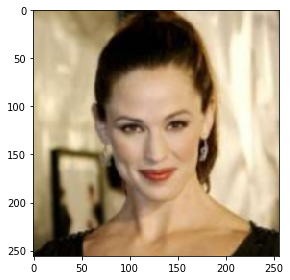

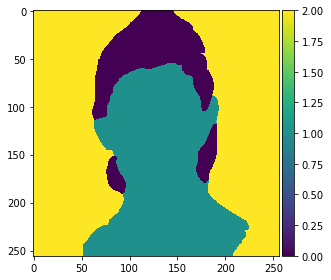

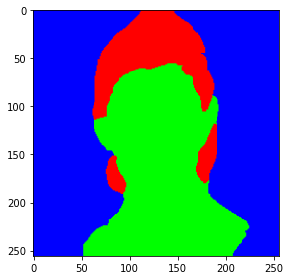

In [0]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train_new[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c10 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c10 = Dropout(0.3) (c10)
c10 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)
p10 = MaxPooling2D(pool_size=(2, 2)) (c10)

# c12 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p10)
# c12 = Dropout(0.3) (c12)
# c12 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c12)
# p12 = MaxPooling2D(pool_size=(2, 2)) (c12)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p10)
c5 = Dropout(0.4) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u13 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
# u13 = concatenate([u13, c12])
# c13 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u13)
# c13 = Dropout(0.3) (c13)
# c13 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c13)

u11 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u11 = concatenate([u11, c10])
c11 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.3) (c11)
c11 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c11)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c11)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(3, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[mean_iou])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 256, 256, 16) 0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [0]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train_new, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 40s 30ms/step - loss: 0.5439 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.3396 - val_sparse_categorical_accuracy: 0.8731

Epoch 00001: val_loss improved from inf to 0.33962, saving model to model-dsbowl2018-1.h5
Epoch 2/100
1350/1350 [==============================] - 36s 27ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.3163 - val_sparse_categorical_accuracy: 0.8848

Epoch 00002: val_loss improved from 0.33962 to 0.31633, saving model to model-dsbowl2018-1.h5
Epoch 3/100
1350/1350 [==============================] - 36s 26ms/step - loss: 0.2694 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.2542 - val_sparse_categorical_accuracy: 0.9053

Epoch 00003: val_loss improved from 0.31633 to 0.25422, saving model to model-dsbowl2018-1.h5
Epoch 4/100
1350/1350 [==============================] - 36s 26ms/step - loss: 0.2474 - sparse_categorical_accuracy: 

In [0]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[:int(X_train.shape[0]*0.1)], verbose=1)
preds_test = model.predict(X_test, verbose=1)
celebA_pred = model.predict(celebA_test, verbose=1)

# print(np.shape(celebA_pred))

# Threshold predictions accounting for multiple channels (hair segmentation)
preds_train_t = (preds_train.argmax(axis=3) == 0).astype(np.uint8)
preds_val_t = (preds_val.argmax(axis=3) == 0).astype(np.uint8)
preds_test_t = (preds_test.argmax(axis=3) == 0).astype(np.uint8)
celebA_pred_t = (celebA_pred.argmax(axis=3) == 0).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i,:,:,0]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
#Create list of unsampled masks for celebA images  
celebA_pred_upsampled = []
for i in range(len(celebA_pred)):
    celebA_pred_upsampled.append(resize(np.squeeze(celebA_pred[i,:,:,0]), 
                                       (sizes_celebA[i][0], sizes_celebA[i][1]), 
                                       mode='constant', preserve_range=True))

1000/1000 [==============================] - 7s 7ms/step


In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train_new[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

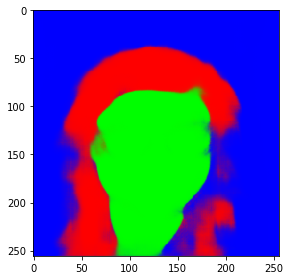

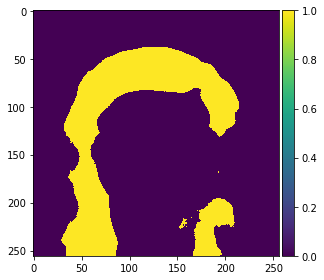

In [0]:
#Sanity check on random celebA samples
ix = random.randint(0, len(celebA_pred_t))
imshow(celebA_pred[ix])
plt.show()
imshow(np.squeeze(celebA_pred_t[ix]))
plt.show()

In [0]:
#Saves masks generated by model to Google Drive
from skimage.io import imsave
TEST_MASK_PATH = '/content/drive/My Drive/cs4990-fall2019-finalproject/testing_masks'
CELEB_A_MASK_PATH = '/content/drive/My Drive/cs4990-fall2019-finalproject/celebA_masks'

def savemask(pred):
  for i in range(len(pred)):
    files = test_ids[i].replace('img','mask')
    imsave(os.path.join(TEST_MASK_PATH,files),pred[i])
savemask(preds_test_upsampled)

def savemask(celeb):
  for i in range(len(celeb)):
    files = celebA_ids[i].replace('.','_mask.')
    imsave(os.path.join(CELEB_A_MASK_PATH,files),celeb[i])
savemask(celebA_pred_upsampled)

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [0]:
# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(TEST_MASK_PATH) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

celebA_masks = [f for f in os.listdir(CELEB_A_MASK_PATH) if f.endswith('.jpg')]
celebA_masks = sorted(celebA_masks, key=lambda s:int([2][0]))

In [0]:
# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(TEST_MASK_PATH, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))

#encode celebA masks
celebA_encodings = []
for file in celebA_masks:
    celebA_mask = imread(os.path.join(CELEB_A_MASK_PATH, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    celebA_mask = np.array(celebA_mask, dtype=np.uint8)
    celebA_mask = np.round(celebA_mask/255)
    encodings.append(rle_encoding(celebA_mask))
  


In [0]:
# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('/content/drive/My Drive/cs4990-fall2019-assignment-3', '/content/drive/My Drive/cs4990-fall2019-assignment-3/finalProject_submission.csv'), index=False)
